# Loading in some data

The below cell loads in a geodata frame -- this is like a fancy excel spreadsheet (a.k.a. pandas dataframe), where each row of the spreadsheet contains information of a precinct in Texas.

Let's print out the first 5 rows of this dataframe to see what kind of data it contains.

In [1]:
import geopandas as gpd

precinct_gdf = gpd.read_file("data/TX_precincts_24/TX_precincts24_with_pop.shp")
precinct_gdf.head(5)

,PRECINCT,COUNTY,CD25,Incumbent2,TOTPOP20,VAP20,BVAP20,HVAP20,AAPIVAP20,AMINVAP20,WVAP20,DVAP22,BDVAP22,HDVAP22,AAPIDVAP22,AMINDVAP22,WDVAP22,geometry
0,1890420,189,19,0,576.0,445.0,4.0,108.0,4.0,3.0,326.0,415.476431,3.977186,93.851003,4.000000,3.000000,310.648241,"POLYGON ((226335.861 3790308.843, 226333.648 3..."
1,1890419,189,19,0,460.0,322.0,0.0,111.0,3.0,3.0,205.0,290.361465,0.000000,92.753425,3.000000,3.000000,191.608040,"POLYGON ((226333.648 3790236.182, 226335.861 3..."
2,1890304,189,19,0,1503.0,1077.0,67.0,476.0,18.0,12.0,504.0,990.184097,63.823529,406.286882,7.230769,9.785325,503.057592,"POLYGON ((248062.528 3787449.003, 248193.83 37..."
3,1890306,189,19,0,214.0,142.0,17.0,82.0,3.0,3.0,37.0,138.702145,17.000000,79.255814,3.000000,2.446331,37.000000,"POLYGON ((247760.43 3786634.764, 247783.302 37..."
4,650402,65,13,0,408.0,323.0,4.0,13.0,1.0,14.0,291.0,319.265423,4.000000,13.000000,0.667201,11.416212,290.182010,"POLYGON ((292770.184 3944754.408, 293383.841 3..."


Each column carries some demographic information about the precincts: for example, "VAP20" stands for the Voting Age Population recorded by the 2020 census in each precinct, and "BVAP20" stands for the recorded Black Voting Age Population.

Because this is a *__geo__*dataframe, the last column carries information about the geometry of each precinct, which we can use to plot the full map of Texas precincts:

<Axes: >

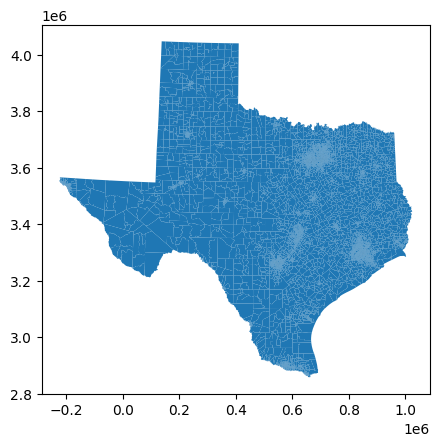

In [2]:
precinct_gdf.plot()

<Axes: >

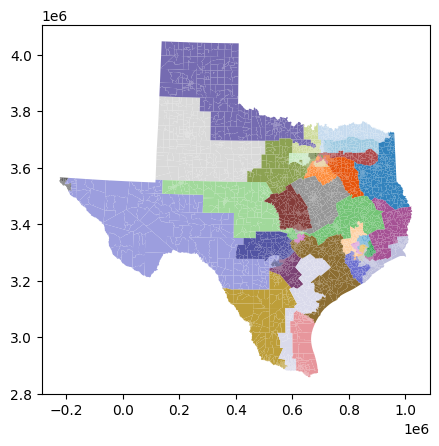

In [26]:
from gerrychain import Graph, Partition
from gerrychain.updaters import Tally

tx_graph = Graph.from_json("data/TX_precincts_24/TX_precincts24_with_pop_and_elections.json")
tx_partition = Partition(tx_graph, assignment="CD25", 
                         updaters={"population": Tally("TOTPOP20", alias="population"), "VAP": Tally("VAP20", alias="VAP20")})
tx_partition.plot(geometries=precinct_gdf, cmap = custom_cmap)

In [46]:
from gerrychain.tree import recursive_tree_part

partition_len = len(tx_partition)
ideal_population = sum(tx_partition["VAP"].values()) / partition_len
print(len(range(1, partition_len + 1)))
initial_partition = recursive_tree_part(tx_graph, range(1, partition_len + 1), pop_target=ideal_population, pop_col="VAP20", epsilon=0.2, node_repeats=10)

38


/home/nardo/projects/texas_gerrychain_demo/.venv/lib/python3.13/site-packages/gerrychain/tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warnings.warn(


KeyboardInterrupt: 

In [4]:
tx_partition.keys()

dict_keys(['cut_edges', 'population', 'VAP'])

In [24]:
from gerrychain import MarkovChain
from gerrychain.constraints import contiguous
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
from gerrychain.tree import bipartition_tree

partition_len = len(tx_partition)
ideal_population = sum(tx_partition["VAP"].values()) / partition_len

proposal = partial(
    recom,
    pop_col="VAP20",
    pop_target=ideal_population,
    epsilon=0.05,
    node_repeats=10,
    method = partial(
        bipartition_tree,
        max_attempts = 100,
        allow_pair_reselection = True
    )
)

recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[],
    accept=always_accept,
    initial_state=tx_partition,
    total_steps=1000
)

assignment_list = []

for i, item in enumerate(recom_chain):
    print(f"Finished step {i+1}/{len(recom_chain)}", end="\r")
    assignment_list.append(item.assignment)

<Axes: >

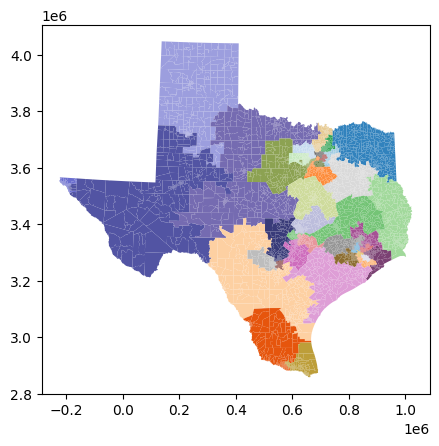

In [25]:
last_assignment = assignment_list[-1]
last_partition = Partition(tx_graph, assignment=last_assignment, updaters={"population": Tally("TOTPOP20", alias="population"), "VAP": Tally("VAP20", alias="VAP20")})
last_partition.plot(geometries=precinct_gdf,cmap = custom_cmap)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:56<00:00,  1.41s/it]


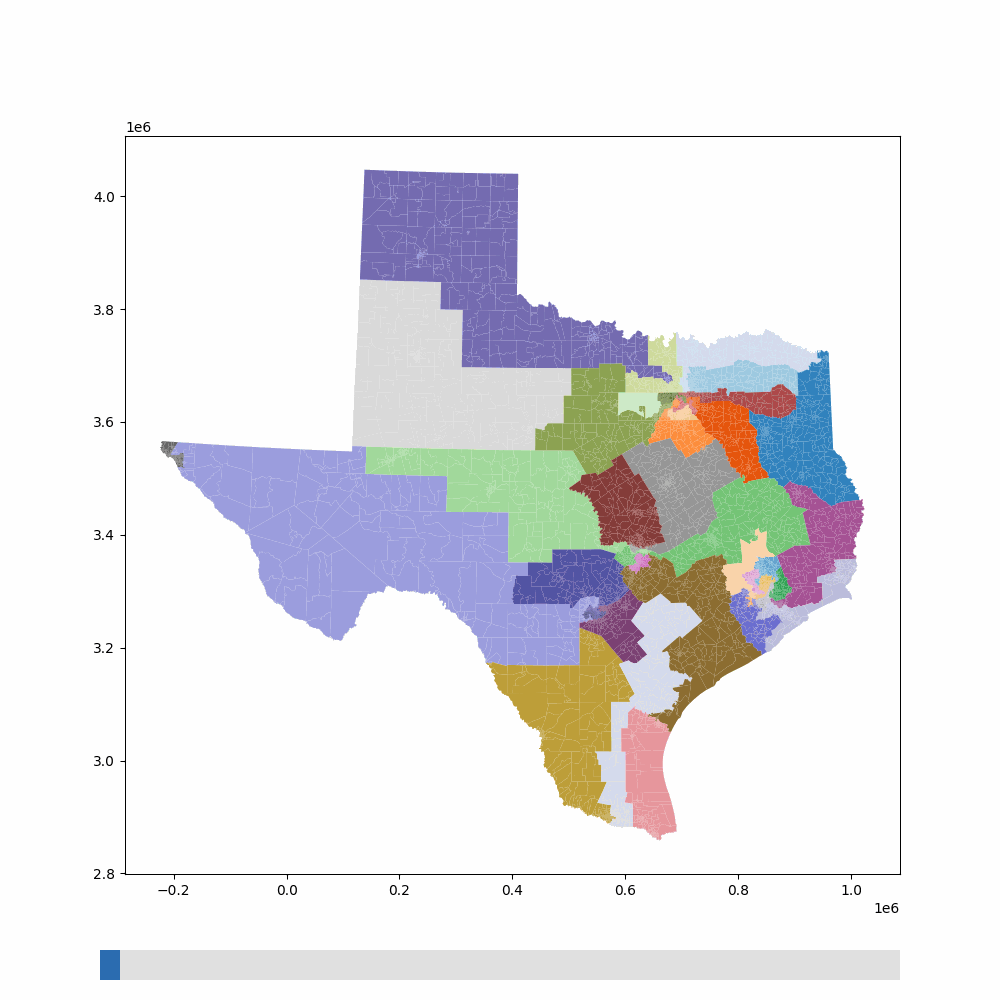

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# append cmap20c and cmap20b
custom_cmap = plt.get_cmap("tab20c")
custom_cmap = custom_cmap(np.arange(custom_cmap.N))
custom_cmap = np.vstack((custom_cmap, plt.get_cmap("tab20b")(np.arange(plt.get_cmap("tab20b").N))))
custom_cmap = plt.matplotlib.colors.ListedColormap(custom_cmap)
custom_cmap

from IPython.display import Image

frames = []
import imageio.v2 as imageio
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_frames = 40
duration = 2   # seconds per frame (slower if larger)
loop = 0         # 0 = infinite loop

with imageio.get_writer("recom_chain.gif", mode="I", duration=duration, loop=loop) as writer:
    for i in tqdm.tqdm(range(n_frames)):
        partition = Partition(tx_graph, assignment=assignment_list[i])
        fig, ax = plt.subplots(figsize=(10, 10))
        partition.plot(geometries=precinct_gdf, cmap=custom_cmap, ax=ax)

        # progress bar (bottom)
        progress = (i + 1) / n_frames
        bar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.03])  # [left, bottom, width, height] in figure coords
        bar_ax.set_xlim(0, 1)
        bar_ax.set_ylim(0, 1)
        bar_ax.axis("off")
        bar_ax.add_patch(Rectangle((0, 0), 1, 1, facecolor="#e0e0e0", edgecolor="none"))
        bar_ax.add_patch(Rectangle((0, 0), progress, 1, facecolor="#2b6cb0", edgecolor="none"))

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = buf.reshape((h, w, 4))
        writer.append_data(frame)
        frames.append(frame)

        plt.close(fig)


#imageio.mimsave("recom_chain.gif", frames, duration=100, loop=0)
Image(filename="recom_chain.gif")


In [30]:
shp_2024 = gpd.read_file("data/TX_precincts_22/Precincts24P.shp")
shp_2024

,CNTY,COLOR,PREC,PCTKEY,cntykey,Shape_area,Shape_len,geometry
0,189,3,0420,1890420,95,3.509673e+08,94959.542440,"POLYGON ((818561.983 1339430.885, 818560.598 1..."
1,189,6,0419,1890419,95,2.864218e+08,86480.840228,"POLYGON ((818415.479 1349979.902, 818813.478 1..."
2,189,1,0304,1890304,95,8.052051e+05,4165.646623,"POLYGON ((840293.586 1336818.978, 840424.75 13..."
3,189,4,0306,1890306,95,2.579397e+05,2025.169890,"POLYGON ((840023.771 1336002.432, 840023.91 13..."
4,65,5,0402,650402,33,1.754785e+08,63243.446522,"POLYGON ((883191.742 1494588.35, 883806.039 14..."
...,...,...,...,...,...,...,...,...
9647,201,7,0357,2010357,101,2.305938e+06,6908.577337,"POLYGON ((1463527.624 889711.491, 1463724.734 ..."
9648,201,3,0098,2010098,101,2.548125e+07,38629.428625,"POLYGON ((1466497.426 890483.996, 1466508.962 ..."
9649,339,3,0054,3390054,170,4.796530e+07,33133.679491,"POLYGON ((1470756.023 901047.208, 1470803.559 ..."
9650,201,5,1085,2011085,101,3.326342e+07,34029.198113,"POLYGON ((1472352.416 896170.71, 1472268.362 8..."


In [ ]:
precinct_gdf


,PRECINCT,COUNTY,CD25,Incumbent2,TOTPOP20,VAP20,BVAP20,HVAP20,AAPIVAP20,AMINVAP20,WVAP20,DVAP22,BDVAP22,HDVAP22,AAPIDVAP22,AMINDVAP22,WDVAP22,geometry
0,1890420,189,19,0,576.0,445.0,4.0,108.0,4.0,3.0,326.0,415.476431,3.977186,93.851003,4.000000,3.000000,310.648241,"POLYGON ((226335.861 3790308.843, 226333.648 3..."
1,1890419,189,19,0,460.0,322.0,0.0,111.0,3.0,3.0,205.0,290.361465,0.000000,92.753425,3.000000,3.000000,191.608040,"POLYGON ((226333.648 3790236.182, 226335.861 3..."
2,1890304,189,19,0,1503.0,1077.0,67.0,476.0,18.0,12.0,504.0,990.184097,63.823529,406.286882,7.230769,9.785325,503.057592,"POLYGON ((248062.528 3787449.003, 248193.83 37..."
3,1890306,189,19,0,214.0,142.0,17.0,82.0,3.0,3.0,37.0,138.702145,17.000000,79.255814,3.000000,2.446331,37.000000,"POLYGON ((247760.43 3786634.764, 247783.302 37..."
4,650402,65,13,0,408.0,323.0,4.0,13.0,1.0,14.0,291.0,319.265423,4.000000,13.000000,0.667201,11.416212,290.182010,"POLYGON ((292770.184 3944754.408, 293383.841 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9652,410047,41,10,0,967.0,682.0,58.0,331.0,4.0,4.0,285.0,576.934300,58.000000,228.649099,2.668802,3.446331,284.170068,"POLYGON ((746266.685 3402507.768, 746322.324 3..."
9653,410108,41,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"POLYGON ((755939.186 3400240.857, 755913.363 3..."
9654,410114,41,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((754407.221 3400565.628, 754413.71 34..."
9655,410081,41,10,0,95.0,81.0,8.0,21.0,0.0,2.0,50.0,80.260313,7.629425,21.000000,0.000000,1.630887,50.000000,"POLYGON ((755095.767 3399326.386, 755083.329 3..."


In [56]:
from gerrychain.constraints.contiguity import contiguous_components

contiguous_components(subset_partition)[key][0].nodes()

NodeView((1552, 1560, 1561, 1562, 1563, 3099, 1566, 1567, 1568, 1569, 1570, 1571, 2084, 2085, 2086, 2087, 3619, 4137, 4138, 4139, 4140, 4141, 4142, 3626, 3627, 7740, 7742, 7752, 4173, 7758, 1105, 3682, 1134, 1139, 3719, 3723, 3726, 3727, 3728, 3231, 2212, 2213, 2214, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 3249, 3250, 3270, 3271, 3272, 3804, 3806, 3807, 3808, 3810, 3811, 3812, 3813, 3814, 3815, 3817, 3818, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 3343, 9494, 9495, 9496, 9497, 9498, 9499, 9500, 9501, 9502, 9503, 9504, 9505, 3367, 9522, 9526, 9527, 9528, 9529, 9530, 9534, 9537, 9540, 9541, 3437, 3451, 9115, 9628, 3997, 9118, 3999, 9119, 9121, 9122, 9123, 9124, 9117, 3014, 9159, 9158, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174))

False

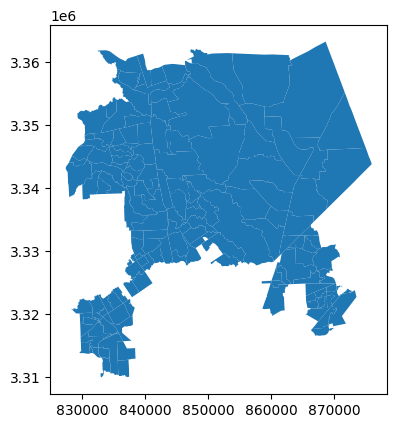

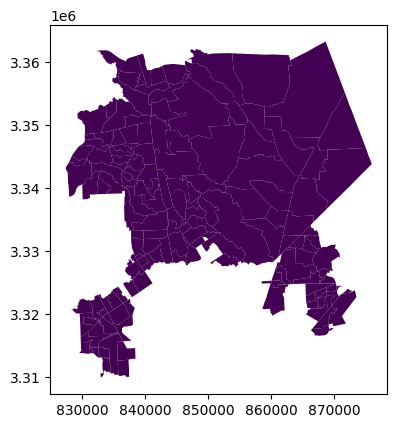

In [40]:

# plot the precincts in the gdf with IDs in this list
#i=0
i+=1
precincts_idx = list(tx_partition.parts[i])
# make this subset of the gdf into a new gdf, then plot it
precincts_subset = precinct_gdf[precinct_gdf.index.isin(precincts_idx)]
precincts_subset.plot()
# turn it into a gerrychain partition and plot it
subset_partition = Partition(tx_graph.subgraph(precincts_idx), assignment="CD25",
                             updaters={"population": Tally("TOTPOP20", alias="population")})
subset_partition.plot(geometries=precincts_subset)
contiguous(subset_partition)

In [45]:
import networkx as nx
next(nx.connected_components(subset_partition.graph))

{1105,
 1134,
 1139,
 1552,
 1560,
 1561,
 1562,
 1563,
 1566,
 1567,
 1568,
 1569,
 1570,
 1571,
 2084,
 2085,
 2086,
 2087,
 2212,
 2213,
 2214,
 2217,
 2218,
 2219,
 2220,
 2221,
 2222,
 2223,
 2224,
 3014,
 3099,
 3231,
 3249,
 3250,
 3270,
 3271,
 3272,
 3343,
 3367,
 3437,
 3451,
 3619,
 3626,
 3627,
 3682,
 3719,
 3723,
 3726,
 3727,
 3728,
 3804,
 3806,
 3807,
 3808,
 3810,
 3811,
 3812,
 3813,
 3814,
 3815,
 3817,
 3818,
 3997,
 3999,
 4137,
 4138,
 4139,
 4140,
 4141,
 4142,
 4173,
 7740,
 7742,
 7752,
 7758,
 9115,
 9117,
 9118,
 9119,
 9121,
 9122,
 9123,
 9124,
 9158,
 9159,
 9165,
 9166,
 9167,
 9168,
 9169,
 9170,
 9171,
 9172,
 9173,
 9174,
 9483,
 9484,
 9485,
 9486,
 9487,
 9488,
 9489,
 9490,
 9491,
 9494,
 9495,
 9496,
 9497,
 9498,
 9499,
 9500,
 9501,
 9502,
 9503,
 9504,
 9505,
 9522,
 9526,
 9527,
 9528,
 9529,
 9530,
 9534,
 9537,
 9540,
 9541,
 9628}

In [ ]:
# find the smallest component of the partition and plot it
smallest_component = min(tx_partition.parts.values(), key=len)

{'boundary_node': False,
 'area': 351877662.17387766,
 'PRECINCT': '1890420',
 'COUNTY': 189,
 'CD25': 19,
 'Incumbent21': 0,
 'TOTPOP20': 576.0,
 'VAP20': 445.0,
 'BVAP20': 4.0,
 'HVAP20': 108.0,
 'AAPIVAP20': 4.0,
 'AMINVAP20': 3.0,
 'WVAP20': 326.0,
 'DVAP22': 415.47643079777094,
 'BDVAP22': 3.977186311787072,
 'HDVAP22': 93.8510032799537,
 'AAPIDVAP22': 4.0,
 'AMINDVAP22': 3.0,
 'WDVAP22': 310.64824120603015,
 'HenryD_RRComm3P14': 0.9999999999999966,
 'BrownD_RRComm3P14': 1.9999999999999964,
 'SpellmonD_RRComm1P18': 2.9999999999999973,
 'McAllenD_RRComm1P18': 0.0,
 'AllenD_SenP12': 0.0,
 'HubbardD_SenP12': 0.0,
 'SadlerD_SenP12': 1.9999999999999964,
 'YarbroughD_SenP12': 0.0,
 'AlonzoD_RRComm1P20': 1.9999999999999964,
 'CastanedaD_RRComm1P20': 0.9999999999999966,
 'StoneD_RRComm1P20': 2.9999999999999973,
 'WatsonD_RRComm1P20': 2.9999999999999973,
 'MahoneyD_CompP18': 2.9999999999999973,
 'ChevalierD_CompP18': 0.0,
 'GarrettD_RRComm1P16': 0.9999999999999966,
 'YarbroughD_RRComm1P16'

True

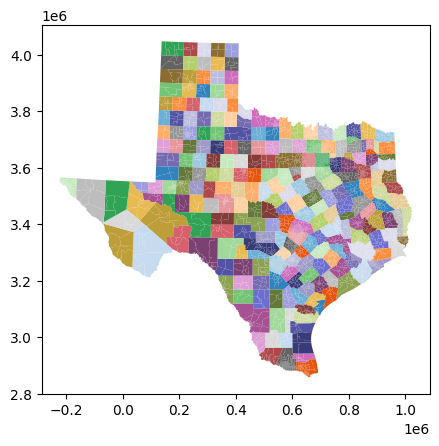

In [36]:
trivial_partition = Partition(tx_graph, assignment="COUNTY",
                             updaters={"population": Tally("TOTPOP20", alias="population")})
trivial_partition.plot(geometries=precinct_gdf, cmap=custom_cmap)
contiguous(trivial_partition)